## Imports

In [384]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scanpy as sc
import bottleneck
from scipy import stats
from scipy import io
import gc
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import joypy
import seaborn as sns

from scipy.cluster import hierarchy

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

from itertools import combinations
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

import networkx as nx
import community
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
import sys
sys.path.append('../scripts/')
sys.path.append('/home/bharris/Correlation_Coexpression/scripts/')
sys.path.append('/home/bharris/vshape/scripts/')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rank import rank
from processify import processify
from egad import run_egad
from egad_by_gene import run_egad_gene_score
import egad_train_test_terms as egad_tt
import biccn_nw_perf_funcs as perf
import load_pearson_networks

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Functions

In [7]:
def iterate_nw_performance(markers, iteration_order, iteration_name, metric):
    cumulative_agg = np.zeros([genes.shape[0], genes.shape[0]])
    agg_performance = []
    for dataset, i in zip(datasets_used[iteration_order],
                          np.arange(len(datasets_used))):
        nw = pd.read_hdf(
            f'/home/bharris/biccn_paper/data/bulk_rna/networks/{dataset}_{metric}_nw.hdf5',
            'nw')
        cumulative_agg += nw.values
        agg_perf = run_egad(markers,
                            pd.DataFrame(cumulative_agg,
                                         index=genes,
                                         columns=genes),
                            min_count=10).AUC
        agg_perf.name = i
        agg_performance.append(agg_perf)

    df = pd.melt(pd.concat(agg_performance, axis=1).reset_index(),
                 id_vars='index')
    df['iteration_name'] = iteration_name
    return df

In [30]:
def compute_nn(k, nw, include_self=False):
    nw_neighbors = (nw.rank(ascending=False)<=k+1).astype(float)
    if not include_self:
        np.fill_diagonal(nw_neighbors.values,0)
    return nw_neighbors

## Load Data

In [12]:
datasets = np.genfromtxt(
    '/home/bharris/biccn_paper/data/bulk_rna/selected_gemma_datasets.txt',
    dtype=str)

In [13]:
genes = perf.genes

In [14]:
go_mouse = pd.read_hdf('/home/bharris/GO_data/go_mouse_nw.hdf5', 'go')

go_ann = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                     index_col='V1')

go_slim = np.genfromtxt('/home/bharris/GO_data/aug4.GOslim', dtype=str)
go_mouse_slim = go_mouse[np.intersect1d(go_mouse.columns, go_slim)]

In [15]:
kegg_tidy = pd.read_csv('/home/bharris/reference_networks/kegg/kegg_all.csv',
                        index_col=0)

kegg_tidy.head()

,V1,V2,V3
1,mmu00010,11674,Aldoa
2,mmu00010,11676,Aldoc
3,mmu00010,230163,Aldob
4,mmu00010,353204,Aldoart1
5,mmu00010,110695,Aldh7a1


In [16]:
kegg_tidy.set_index('V3', inplace=True)

kegg_genes = np.unique(kegg_tidy.index.values)

kegg_terms = np.unique(kegg_tidy.V1.values)

kegg = pd.DataFrame(0, index=kegg_genes, columns=kegg_terms)
for i, j in kegg_tidy[['V1']].groupby('V1').groups.items():
    kegg.at[j, i] = 1

## Compute Aggregate Nw

We read in each dataset and aggregate them together.

We also compute Supplementary Figure 3B

In [17]:
agg_brain_nw = np.zeros([genes.shape[0], genes.shape[0]])
datasets_used = []
for dataset in datasets:
    nw = pd.read_hdf(
        f'/home/bharris/biccn_paper/data/bulk_rna/networks/{dataset}_pearson_nw.hdf5',
        'nw')
    if np.all(np.isnan(nw.values)):
        logging.info(f'{dataset} is all nans')
        continue
    agg_brain_nw += nw.values
    del nw
    datasets_used.append(dataset)
    gc.collect()
agg_brain_nw = pd.DataFrame(rank(agg_brain_nw), index=genes, columns=genes)

2020-01-31 09:45:35,365 - GSE98401 is all nans
2020-01-31 09:45:35,621 - GSE100225 is all nans
2020-01-31 09:45:37,047 - GSE102992 is all nans
2020-01-31 09:45:38,095 - GSE72826 is all nans
2020-01-31 09:45:41,841 - GSE73391 is all nans
2020-01-31 09:45:43,125 - GSE93097 is all nans
2020-01-31 09:45:43,643 - GSE111660 is all nans
2020-01-31 09:45:46,429 - GSE94482 is all nans
2020-01-31 09:45:47,755 - GSE102204 is all nans


In [567]:
np.savetxt('/home/bharris/biccn_paper/data/bulk_rna/datasets_used.csv',
           datasets_used,
           fmt='%s')

In [15]:
dataset_size = {}
for dataset in datasets_used:
    data = pd.read_csv(
        f'/home/bharris/biccn_paper/data/bulk_rna/gemma_parsed_expression/{dataset}_expression.csv',
        index_col=0)
    dataset_size[dataset] = data.shape[1]
    del data
    gc.collect()

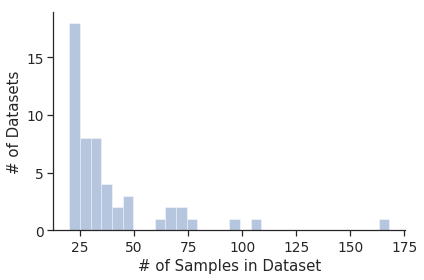

In [595]:
ax = sns.distplot(pd.Series(dataset_size, name='# of Samples'),
                  kde=False,
                  bins=30)
ax.set(xlabel='# of Samples in Dataset', ylabel='# of Datasets')
plt.tight_layout()
plt.savefig('/home/bharris/biccn_paper/figures/bulk_dataset_sizes.pdf')

## GO and KEGG performance

Here we compute Supplementary Figure 3C

In [104]:
dataset_order = np.arange(len(datasets_used), dtype=int)

iterative_go_performance = []
for iteration in np.arange(50):
    np.random.shuffle(dataset_order)
    iterative_go_performance.append(
        iterate_nw_performance(go_mouse_slim, dataset_order, iteration))

In [70]:
dataset_order = np.arange(len(datasets_used), dtype=int)

iterative_kegg_performance = []
for iteration in np.arange(50):
    np.random.shuffle(dataset_order)
    iterative_kegg_performance.append(
        iterate_nw_performance(kegg, dataset_order, iteration))

In [295]:
go_iterated = pd.concat(iterative_go_performance).groupby(
    ['variable', 'iteration_name']).mean().reset_index()
go_iterated['reference'] = 'GO Slim'
kegg_iterated = pd.concat(iterative_kegg_performance).groupby(
    ['variable', 'iteration_name']).mean().reset_index()
kegg_iterated['reference'] = 'KEGG'
iterated_combined = pd.concat([ go_iterated, kegg_iterated])

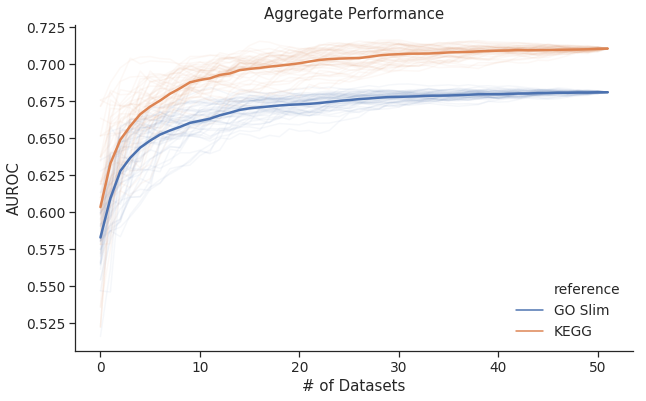

In [348]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=iterated_combined,
             x='variable',
             y='value',
             ci=None,
             estimator=None,
             hue='reference',
             units='iteration_name',
             ax=ax,
             alpha=.05)
sns.lineplot(data=iterated_combined,
             x='variable',
             y='value',
             ci=None,
             hue='reference',
             ax=ax,
             linewidth=2.5,
             legend=False)
ax.set(xlabel='# of Datasets', ylabel='AUROC', title='Aggregate Performance')
ax.legend(frameon=False)
plt.savefig(
    '/home/bharris/biccn_paper/figures/bulk_rna_kegg_go_performance.pdf')

### Bootstrap Network

Here we read in the results from 100 bootstraps of the network created in `bootstrap_bulk_nw_perf.py` and produce the joyplot in Figure 3a

In [45]:
subclass_colors = pd.read_csv(
    '/home/bharris/biccn_paper/data/subclass_colors.csv',
    index_col=1,
    header=None)
replace_space = np.vectorize(lambda x: x.replace(' ', '.'))
replace_slash = np.vectorize(lambda x: x.replace('/', '.'))
subclass_colors.index = replace_slash(replace_space(subclass_colors.index))

In [48]:
marker_bootstrap_df = pd.read_csv('/home/bharris/biccn_paper/data/bulk_rna/bootstrap_100_markers.csv',index_col=0).reset_index()
marker_bootstrap_df.rename(columns={'index': 'label'}, inplace=True)

In [63]:
subclass_order = subclass_colors[np.in1d(
   subclass_colors.index, np.unique(marker_bootstrap_df.label.values))].index
# subclass_order = marker_bootstrap_df[~marker_bootstrap_df.label.isin(
#     ['GABAergic', 'Glutamatergic', 'Non.Neuronal'])].groupby(
#         'label').mean().AUC.sort_values().index
subclass_palette = sns.color_palette(
    subclass_colors.loc[subclass_order][0].values, desat=.5)

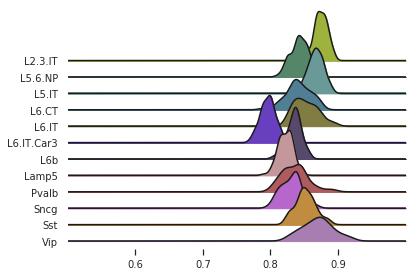

In [457]:
temp = marker_bootstrap_df.loc[~marker_bootstrap_df.label.isin(['GABAergic', 'Glutamatergic', 'Non.Neuronal','L5.ET']),['label','AUC']]

cmap = []
for row in np.sort(temp.label.unique()):
    cmap.append(sns.desaturate(colors.to_rgba(subclass_colors.loc[row,0]),.5))
subclass_cm = colors.ListedColormap(cmap)

joypy.joyplot(temp,by='label',colormap=subclass_cm, x_range=[.5,1])
plt.savefig('/home/bharris/biccn_paper/figures/bulk_bootstrapping_markers_joyplot.pdf',transparent=True)

## Compare Local Network topology

Here we compute ther result for Figure 2d

We compute nearest neighbors for each gene in each network and measure the performance of those modules in the other network

In [ ]:
metacells_nw = pd.read_hdf('/home/bharris/biccn_paper/data/metacells/aggregate_metacells_nws.hdf5','nw')

In [31]:
k = 10
metacells_nn = compute_nn(k, metacells_nw)
bulk_nn = compute_nn(k, agg_brain_nw)

In [32]:
nn_eg = run_egad(metacells_nn, agg_brain_nw, min_count=3).sort_values('AUC',ascending=False)
nn_eg+meta = run_egad(bulk_nn, metacells_nw, min_count=3).sort_values('AUC',ascending=False)

/home/bharris/Correlation_Coexpression/scripts/egad.py:105: RuntimeWarning: divide by zero encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/home/bharris/Correlation_Coexpression/scripts/egad.py:105: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n


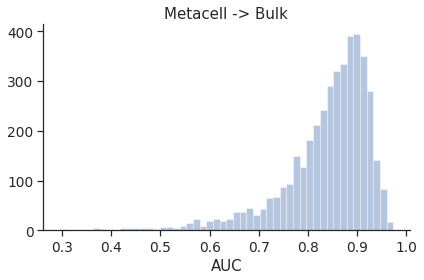

In [361]:
ax=sns.distplot(nn_eg.AUC,kde=False,norm_hist=False)
ax.set(title='Metacell -> Bulk',)
plt.tight_layout()
#plt.savefig('/home/bharris/biccn_paper/figures/topology_agg_metacell_on_bulk.pdf',transparent=True)

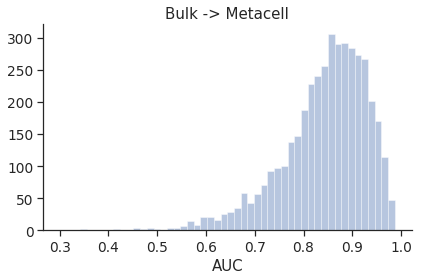

In [360]:
ax=sns.distplot(nn_eg_meta.AUC,kde=False,norm_hist=False)
ax.set(title='Bulk -> Metacell',)
plt.tight_layout()
#plt.savefig('/home/bharris/biccn_paper/figures/topology_agg_bulk_on_metacell.pdf',transparent=True)